# Reconstruction of a femtosecond laser written waveguide

This notebook shows how to reconstruct the cross-section of a longitudinally invariant waveguide from a 2D tomogram, which is a stack of intensity profiles recorded for different illumination angles.

The method used is the one described in the article [1]:

[1] *Nicolas Barré, Ravi Shivaraman, Lisa Ackermann, Simon Moser, Michael Schmidt, Patrick Salter, Martin Booth, and Alexander Jesacher. "Tomographic refractive index profiling of direct laser written waveguides." Optics Express 29, no. 22 (2021): 35414-35425.*

In [1]:
using FFTW
using JLD
using PyPlot

In [2]:
FFTW.set_num_threads(4)

In [3]:
include("../src/proximal_optim.jl")
include("../src/model.jl")

compute_grad_wg_Zk! (generic function with 1 method)

In [4]:
# we load the tomogram data which contains the intensity map I,
# the camera pixel pitch dx and the angle range θ_l in radians.

tomogram_data = load("../data/tomogram_guide_b.jld")

Dict{String, Any} with 3 entries:
  "I"   => [0.83158 0.906255 … 0.999039 1.00958; 0.832955 0.908031 … 1.00015 1.…
  "dx"  => 0.0405
  "θ_l" => [1.00424, 0.945811, 0.880387, 0.822474, 0.769674, 0.720691, 0.673101…

In [5]:
dx = tomogram_data["dx"]
I_map = tomogram_data["I"]
θ_l = tomogram_data["θ_l"];

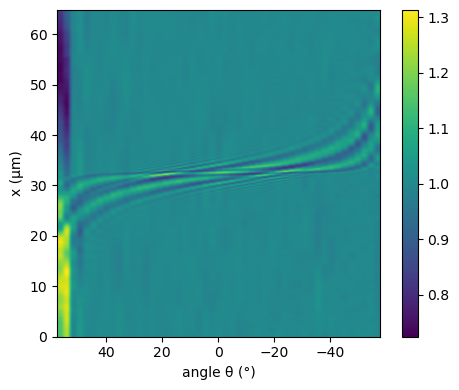

In [6]:
figure(figsize=(5,4))
imshow(I_map, aspect=1.8, extent=[θ_l[1]*180/pi,θ_l[end]*180/pi, 0,dx*size(I_map,1)])
colorbar()
xlabel("angle θ (°)")
ylabel("x (μm)")
tight_layout()

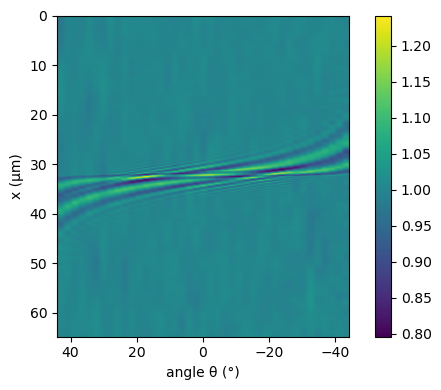

In [7]:
# We keep only a portion of the tomogram to avoid aberrations and recording issues at large angles.

l_i = (25-20):(25+20)
θ_l_i = θ_l[l_i]
I_map_i = I_map[:,l_i]
I_map_i .*= size(I_map_i, 1)./sum(I_map_i, dims=1)

nx = size(I_map_i, 1)

figure(figsize=(5.5,4))
imshow(I_map_i, aspect=1.5, extent=[θ_l_i[1]*180/pi,θ_l_i[end]*180/pi, nx*dx,0])
colorbar()
xlabel("angle θ (°)")
ylabel("x (μm)")
tight_layout()

In [8]:
n0 = 1.52 # bulk refractive index
λ = 0.455 # illumination wavelength in µm
n_views = size(θ_l_i)

(41,)

In [9]:
# We define the resolution in depth z that we want for the reconstruction.

Lz = 20 # must be larger than the guide extent in z
nz = 300
dz = Lz/(nz-1)

0.06688963210702341

In [10]:
# We need to estimate the distance between the centre of the sample and the plane imaged by the camera.
# It can be a bit wrong, the consequence is that the reconstructed profile may not appear in the
# center of the grid.

Δsample = -6 # in µm

NA = 1.4 # numerical aperture of the microscope objective

1.4

In [11]:
# We build the main simulation structure containing all the necessary data to proceed to a reconstruction.
# nzk represent the degree of the maximum polynomial we want to use to model aberrations in the pupil plane
# of the microscope objective. The aberration profile will be reconstructed in a joint optimization along
# with the waveguide transverse profile.

nzk = 10
wg = Wg_bpm_ϕ(λ, n0, nx, nz, dx, dz, Δsample, NA, I_map_i, θ_l_i; nzk=nzk);

In [12]:
RI = zeros((nx,nz))
RI .= n0 # initialization to bulk RI

∇RI = similar(RI)

nZk = size(wg.Zkv,3)
Zkv = zeros(nZk)
∇Zkv = similar(Zkv)
∇Zkv .= 0

TV_prox! = get_FTV_prox!(RI, 2e-6,
                         n_iter=10)

#12 (generic function with 1 method)

In [13]:
L = 5e5 # Lipschitz constant for RI reconstruction.
RI_method = Fista(RI, L) # optimization method for RI reconstruction.

LZk = 5e3 # Lipschitz constant for aberration reconstruction.
Zkv_method = Fista(Zkv, LZk) # optimization method for aberration reconstruction.

methods = (RI_method, Zkv_method);

In [14]:
# We run the main optimization.
# Try first with a small number of iterations to see if your parameters are fine.

ProgressMeter.ijulia_behavior(:clear)

errors = []
@time proximal_iter!((RI,Zkv), (∇RI,∇Zkv),
                               wg,
                               compute_fwd_wg_Zk!,
                               compute_err_wg!,
                               compute_grad_wg_Zk!,
                               methods,
                               30;
                               prox! = (TV_prox!, identity),
                               errors=errors, restart=true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29
  error:  0.22098118106984604


 31.716867 seconds (171.51 M allocations: 26.588 GiB, 6.64% gc time)


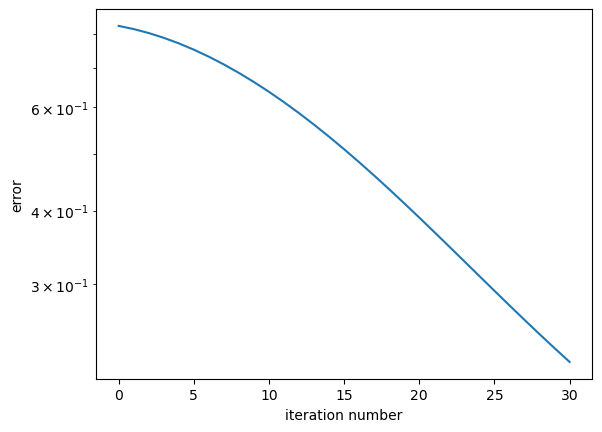

PyObject Text(24.0, 0.5, 'error')

In [15]:
figure()
semilogy(errors)
xlabel("iteration number")
ylabel("error")

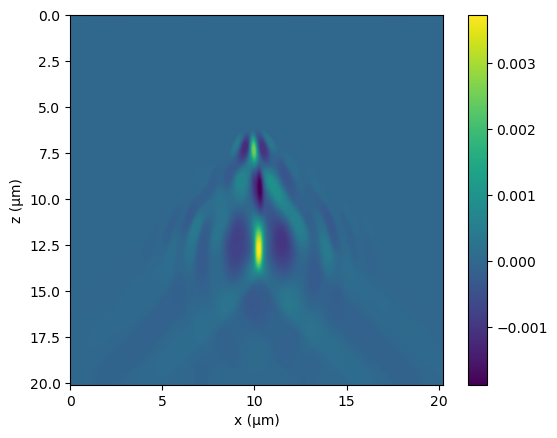

PyObject Text(0.5, 24.0, 'x (µm)')

In [16]:
# We can visualize the RI reconstruction result
# We see a lot of artifacts when the algorithm is not converged, but we are on a good way.

ncut = 550 # we cut the x dimension for better visualization

dn = (RI_method.xk .- n0)[:,end:-1:1] # we subtract the bulk RI and recover the proper orientation

dn_cut = dn[(1+ncut):(end-ncut),:]'

figure()
imshow(dn_cut, extent=[0, (nx-2*ncut)*dx, nz*dz, 0])
colorbar()
ylabel("z (µm)")
xlabel("x (µm)")

In [17]:
# We perform a few hundreds more iterations.

errors = []
@time proximal_iter!((RI,Zkv), (∇RI,∇Zkv),
                               wg,
                               compute_fwd_wg_Zk!,
                               compute_err_wg!,
                               compute_grad_wg_Zk!,
                               methods,
                               300;
                               prox! = (TV_prox!, identity),
                               errors=errors, restart=true);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:37
  error:  0.06829865180306924


278.196575 seconds (1.59 G allocations: 257.683 GiB, 7.02% gc time)


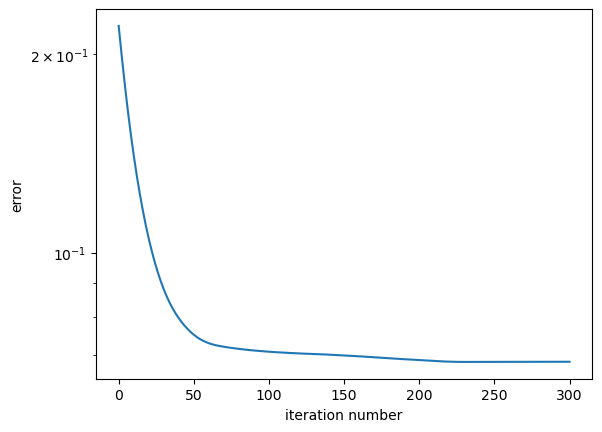

PyObject Text(24.0, 0.5, 'error')

In [18]:
figure()
semilogy(errors)
xlabel("iteration number")
ylabel("error")

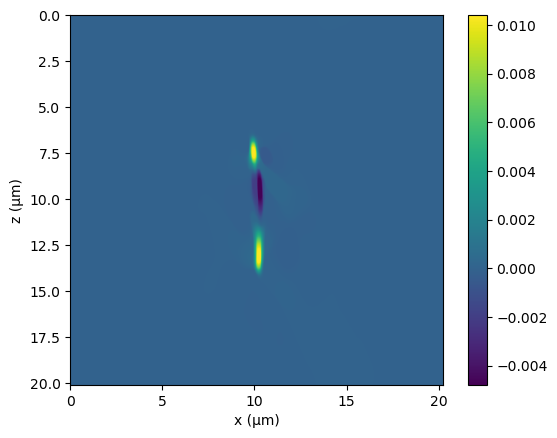

PyObject Text(0.5, 24.0, 'x (µm)')

In [19]:
# The reconstruction now looks nicer.

dn = (RI_method.xk .- n0)[:,end:-1:1]

dn_cut = dn[(1+ncut):(end-ncut),:]'

figure()
imshow(dn_cut, extent=[0, (nx-2*ncut)*dx, nz*dz, 0])
colorbar()
ylabel("z (µm)")
xlabel("x (µm)")

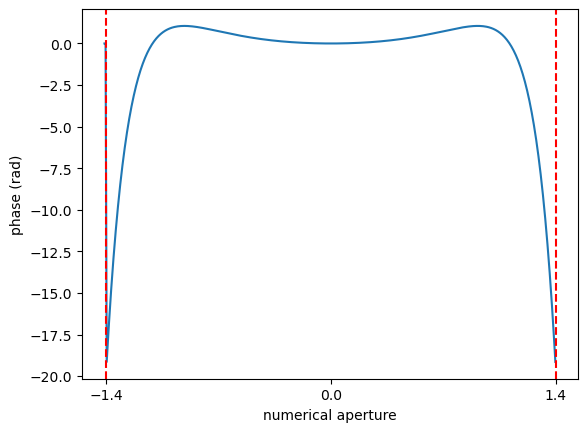

(PyCall.PyObject[PyObject <matplotlib.axis.XTick object at 0x7fb3cbb7ea30>, PyObject <matplotlib.axis.XTick object at 0x7fb3cbb7ea00>, PyObject <matplotlib.axis.XTick object at 0x7fb3cbb73f40>], PyCall.PyObject[PyObject Text(-1.4, 0, '−1.4'), PyObject Text(0.0, 0, '0.0'), PyObject Text(1.4, 0, '1.4')])

In [20]:
# We can also visualize the aberration radial profile.

function get_aberration(nx, dx, λ, n0, NA, zkv)
    pmax = length(zkv)
    fxv = fftfreq(nx, 1/dx)
    defocus = [if abs(fx) <= abs(NA/λ);
               sqrt(1/(λ/n0)^2-fx^2) - n0/λ;
               else 0.0 end for fx in fxv]
    l = [if abs(fx) <= abs(NA/λ); (abs(fx)*λ/NA)^(2*p); else 0.0 end
         for fx in fxv, p in 1:pmax-1]
    A = sum(l .* zkv[2:end]', dims=2)[:,1]
    fftshift(fxv)*λ, fftshift(A .+ zkv[1]*defocus)
end

NA_v, aberr = get_aberration(nx, dx, λ, n0, NA, Zkv)

nfcut = 600

figure()
plot(NA_v[nfcut:end-nfcut], aberr[nfcut:end-nfcut])
axvline(x=NA, ls="--", color="red")
axvline(x=-NA, ls="--", color="red")
xlabel("numerical aperture")
ylabel("phase (rad)")
xticks([-NA, 0, NA])